In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import torch
from sklearn.metrics import r2_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:

# CSV(목푯값) 불러오는 함수 -> 첫 번째 열(이미지 이름) 제외
def load_csv(csv_path):
    df = pd.read_csv(csv_path, header=None)
    joint = df.iloc[:, 1:].to_numpy()
    return joint

#
def load_csv_first_col(csv_path):
    df = pd.read_csv(csv_path, header=None)
    joint = df.iloc[:, 0:1].to_numpy().flatten()
    return joint

y_train = load_csv("./joint_train.csv")

print('original: ',y_train[0][:])

for i in range(len(y_train)):
    if y_train[i][6] > y_train[i][10]:
        for j in range(6,10):
            tmp = y_train[i][j]
            y_train[i][j] = y_train[i][j+4]
            y_train[i][j+4] = tmp

    if y_train[i][14] > y_train[i][18]:
        for j in range(14,18):
            tmp = y_train[i][j]
            y_train[i][j] = y_train[i][j+4]
            y_train[i][j+4] = tmp
            
def rotate_points(points):
    rotated_points = np.zeros_like(points)  # 회전된 좌표 저장할 배열

    # 각 행별로 회전 적용
    for i in range(points.shape[0]):
        x1, y1, x2, y2 = points[i, 0:4]  # c1, c2 좌표 추출
        dx = x2 - x1  # c1, c2 x 좌표 차이 계산

        # 회전 각도 계산
        if dx != 0:
            angle = np.arctan(dx / (y2 - y1))  # 각도 계산
        else:
            angle = 0

        # 회전 변환 행렬 생성
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                    [np.sin(angle), np.cos(angle)]])

        # 회전 적용
        rotated_points[i, :] = np.dot(rotation_matrix, points[i, :].reshape(-1, 2).T).T.flatten()

    return rotated_points


rotated_y_train = rotate_points(y_train)


print('rotated: ', rotated_y_train[0][:])

original:  [155 172 143  85 137  73 169 118 195 150 125 124 106 163 184 221 214 270
 132 223 109 274]
rotated:  [130 191 130 103 125  91 106 139  82 175 151 139 172 175 100 238  70 286
 152 244 175 296]


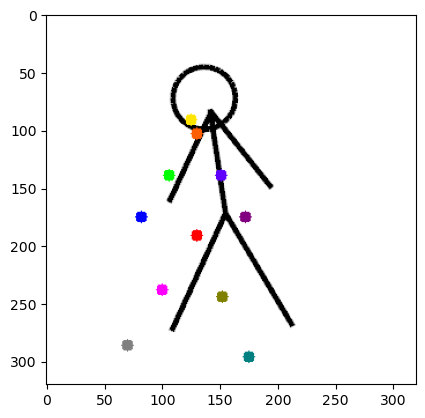

In [4]:
imageFile = './image_train/sf000000.png'
img = cv2.imread(imageFile)

# data=predictions[0]
data=rotated_y_train[0]

c1_x = int(round(data[0]))           
c1_y = int(round(data[1]))            
c2_x = int(round(data[2]))             
c2_y = int(round(data[3]))             
c3_x = int(round(data[4]))             
c3_y = int(round(data[5]))             
le_x = int(round(data[6]))             
le_y = int(round(data[7]))            
lh_x = int(round(data[8]))             
lh_y = int(round(data[9]))             
re_x = int(round(data[10]))             
re_y = int(round(data[11]))             
rh_x = int(round(data[12]))             
rh_y = int(round(data[13]))             
lk_x = int(round(data[14]))             
lk_y = int(round(data[15]))              
lf_x = int(round(data[16]))             
lf_y = int(round(data[17]))             
rk_x = int(round(data[18]))             
rk_y = int(round(data[19]))             
rf_x = int(round(data[20]))             
rf_y = int(round(data[21]))  



cv2.circle(img,(c1_x,c1_y), radius=5, color=(0,0,255), thickness=-1)  #빨
cv2.circle(img,(c2_x,c2_y), radius=5, color=(0,94,255), thickness=-1)  #주
cv2.circle(img,(c3_x,c3_y), radius=5, color=(0,228,255), thickness=-1) #노
cv2.circle(img,(le_x,le_y), radius=5, color=(0,255,0), thickness=-1)  #초
cv2.circle(img,(lh_x,lh_y), radius=5, color=(255,0,0), thickness=-1)  #파
cv2.circle(img,(re_x,re_y), radius=5, color=(255,0,95), thickness=-1)
cv2.circle(img,(rh_x,rh_y), radius=5, color=(128,0,128), thickness=-1)
cv2.circle(img,(lk_x,lk_y), radius=5, color=(255,0,255), thickness=-1)
cv2.circle(img,(lf_x,lf_y), radius=5, color=(128,128,128), thickness=-1)
cv2.circle(img,(rk_x,rk_y), radius=5, color=(0,128,128), thickness=-1)
cv2.circle(img,(rf_x,rf_y), radius=5, color=(128,128,0), thickness=-1)


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#이미지, 점 출력
plt.imshow(img)
plt.show()


In [5]:
# 이미지 회전

- 이미지도 회전 -> angle에 저장된 숫자로
- 이미지 사이즈 줄이기 전에 회전하기(?)

- 320*320 밖으로 나가는 점 해결(예외처리)



------------------------------------------------
물구나무 이미지가 애초에 많지 않아서 train data에서 학습하지 못한듯
-> 물구나무 이미지 임의로 만들어서(데이터 증강) 학습해볼까
발차기는 이제 잘 찾음

# model_1 : 점 c1,c2 찾기
# model_2 : 회전된 이미지 기반으로 모든 점 찾기

1. 점 c1, c2만 찾는 모델(model_1) 학습
2. model_1 으로 test data 이미지 회전
3. train data 이미지 회전
4. 회전된 train data 이미지로 모든 점 찾는 모델(model_2) 학습
5. model_2 로 회전된 test data 이미지에서 모든 점 찾기
6. 회전값 반대로 적용해서 정답 출력
 
